# Домашнее задание №2

In [58]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm

## 1. Чтение и анализ данных

Прочитайте и проанализируйте данные, выберите турниры, в которых есть данные о составах команд и повопросных результатах (поле mask в results.pkl). Для унификации:
* взять в тренировочный набор турниры с dateStart из 2019 года; 
* в тестовый — турниры с dateStart из 2020 года.


In [1]:
# !apt install unzip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-21ubuntu1.1).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.


In [92]:
# FILES_PATH = "drive/MyDrive/2-ml_hw2/"

In [1]:
!unzip "./chgk.zip" -d "./"

Archive:  ./chgk.zip
  inflating: ./players.pkl           
  inflating: ./results.pkl           
  inflating: ./tournaments.pkl       


In [5]:
with open('./players.pkl', 'rb') as f:
    players = pd.DataFrame(pickle.load(f)).T   
with open('./results.pkl', 'rb') as f:
    results = pickle.load(f)
with open('./tournaments.pkl', 'rb') as f:
    tournaments = pickle.load(f)

In [6]:
df_players = pd.DataFrame.from_dict(players).set_index('id')
df_tournaments = pd.DataFrame.from_dict(tournaments, orient='index').set_index('id')

Выкидываем записи с пропущенными данными о вопросах, а также записи, где фигурируют 'X' или '?' вместо вопроса. Делим данные на трейн и тест по дате, оставляем нужные переменные.



In [7]:
def skip_flag(quest_tags):
    flag = 0
    if len(quest_tags) > 2:
        flag += 1
    if 'X' in quest_tags or '?' in quest_tags:
        flag += 1
    return flag

def create_team_dict(team, team_temp):
    team['id'] = team_temp['team']['id']
    team['name'] = team_temp['team']['name']
    team['position'] = team_temp['position']
    team['mask'] = team_temp['mask']
    team['questions_amount'] = len(team_temp['mask'])
    team_members = []
    for team_member in team_temp['teamMembers']:
        team_members.append(team_member['player']['id'])
    team['team_members'] = team_members
    return team

def find_teams_result(result):
    teams = []
    questions_amount = set()
    for team_temp in result:
        team = {}
        if not team_temp.get('mask'):
            return None
        questions_amount.add(len(team_temp.get('mask')))
        quest_tags = set(team_temp.get('mask'))
        if skip_flag(quest_tags) != 0 :
            continue
        team = create_team_dict(team, team_temp)      
        teams.append(team)
    if len(questions_amount) != 1:
        return None
    return teams

def train_test_split_data(results, tournaments):        
    data_train = []
    data_test = []      
    for id_tour in results:
        tour = {}
        if not results[id_tour] or len(results[id_tour]) < 1:
            continue
        date_start = tournaments[id_tour]['dateStart']
        year_tour = pd.to_datetime(date_start).year
        if year_tour not in [2019, 2020]:
            continue
        teams_result = find_teams_result(results[id_tour])
        if not teams_result:
            continue
        tour['id'] = id_tour
        tour['teams'] = teams_result

        if year_tour == 2019:
            data_train.append(tour)
        elif year_tour == 2020:
            data_test.append(tour)
    return data_train, data_test

In [8]:
data_train, data_test = train_test_split_data(results, tournaments)
print('Размер трейна:', len(data_train), 'и теста:', len(data_test))

Размер трейна: 601 и теста: 152


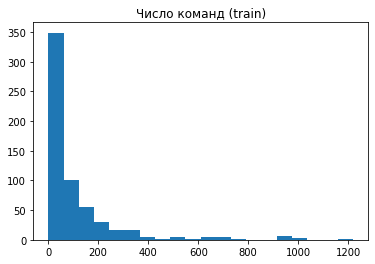

In [9]:
teams_amounts = []
for tour in data_train:
    teams_amount = len(tour['teams'])
    teams_amounts.append(teams_amount)
plt.hist(teams_amounts, bins=20)
plt.title('Число команд (train)')
plt.show()

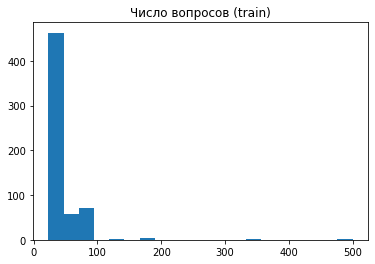

In [10]:
questions_amounts = []
for tour in data_train:
    questions_amount = len(tour['teams'][0]['mask'])
    questions_amounts.append(questions_amount)
plt.hist(questions_amounts, bins=20)
plt.title('Число вопросов (train)')
plt.show()

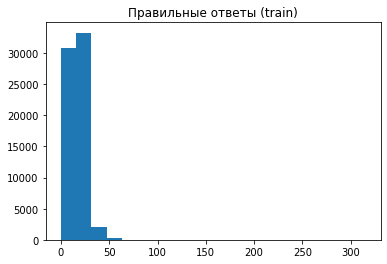

In [11]:
right_answer_amounts = []
for tour in data_train:
  for team in tour['teams']:
    right_answer_amount = sum([int(el) for el in team['mask']])
    right_answer_amounts.append(right_answer_amount)
plt.hist(right_answer_amounts, bins=20)
plt.title('Правильные ответы (train)')
plt.show()

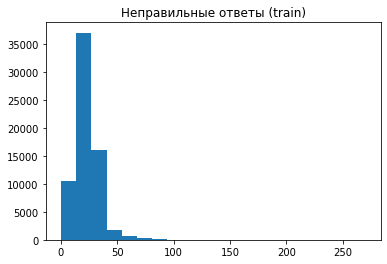

In [12]:
wrong_answer_amounts = []
for tour in data_train:
  for team in tour['teams']:
    wrong_answer_amount = [int(el) for el in team['mask']].count(0)
    wrong_answer_amounts.append(wrong_answer_amount)
plt.hist(wrong_answer_amounts, bins=20)
plt.title('Неправильные ответы (train)')
plt.show()

## 2. Baseline-модель

Постройте baseline-модель на основе линейной или логистической регрессии, которая будет обучать рейтинг-лист игроков. Замечания и подсказки:
* повопросные результаты — это фактически результаты броска монетки, и их предсказание скорее всего имеет отношение к бинарной классификации;
* в разных турнирах вопросы совсем разного уровня сложности, поэтому модель должна это учитывать; скорее всего, модель должна будет явно обучать не только силу каждого игрока, но и сложность каждого вопроса;
* для baseline-модели можно забыть о командах и считать, что повопросные результаты команды просто относятся к каждому из её игроков.


In [13]:
df_data = []
for tour in data_train:
    tour_id = tour['id']
    for team in tour['teams']:
        answers = [int(el) for el in team['mask']]
        members = team['team_members']
        for question_num in range(len(answers)):
            for member in members:
                new_row = {'member': member, 'tour_id': tour_id, 'question_num': question_num + 1, 'question_status': answers[question_num]}
                df_data.append(new_row)

In [16]:
members = []
tour_ids = []
question_nums = []
question_statuses = []
for i in tqdm(range(len(df_data))):
    members.append(df_data[i]['member'])
    tour_ids.append(df_data[i]['tour_id'])
    question_nums.append(df_data[i]['question_num'])
    question_statuses.append(df_data[i]['question_status'])

df = pd.DataFrame({'member': members, 'tour_id': tour_ids, 'question_num': question_nums, 'question_status': question_statuses})
df

100%|██████████| 13715187/13715187 [00:09<00:00, 1392590.35it/s]


,member,tour_id,question_num,question_status
0,6212,4772,1,1
1,18332,4772,1,1
2,18036,4772,1,1
3,22799,4772,1,1
4,15456,4772,1,1
...,...,...,...,...
13715182,217855,6191,36,0
13715183,217856,6191,36,0
13715184,217857,6191,36,0
13715185,217858,6191,36,0


In [17]:
members_data = np.array(df)
X_train, y_train = members_data[:, :3], members_data[:, 3].astype(bool)

encoder = OneHotEncoder()
X_train_onehot = encoder.fit_transform(X_train)

In [20]:
lr = LogisticRegression(solver='saga', random_state=5)
lr.fit(X_train_onehot, y_train)

accuracy_score(lr.predict(X_train_onehot), y_train)

0.658444175788489

Топ-10 игроков

In [44]:
categ = encoder.categories_[0]
power = lr.coef_.ravel()[:encoder.categories_[0].shape[0]]
full = np.vstack([categ.astype(int), power.astype(float)]).T
top = full[full[:, 1].argsort()][::-1][:10, 0]
df.loc[top.astype(int)]

,member,tour_id,question_num,question_status
27403,158734,4772,20,0
4270,171798,4772,28,0
28751,183347,4772,4,1
27822,98697,4772,18,1
30152,125567,4772,15,0
30270,132214,4772,6,1
18036,27042,4772,1,1
20691,32345,4772,11,1
22799,23539,4772,26,0
26089,35769,4772,6,1


## 3. Оценка качества модели

Качество рейтинг-системы оценивается качеством предсказаний результатов турниров. Но сами повопросные результаты наши модели предсказывать вряд ли смогут, ведь неизвестно, насколько сложными окажутся вопросы в будущих турнирах; да и не нужны эти предсказания сами по себе. Поэтому:
* предложите способ предсказать результаты нового турнира с известными составами, но неизвестными вопросами, в виде ранжирования команд;
* в качестве метрики качества на тестовом наборе давайте считать ранговые корреляции Спирмена и Кендалла (их можно взять в пакете scipy) между реальным ранжированием в результатах турнира и предсказанным моделью, усреднённые по тестовому множеству турниров